# 青空文庫の著者推定システム

青空文庫に掲載されている作品の文体的特徴を解析し、機械学習を用いて著者を推定するシステムを構築します。

## プロジェクト概要
- **目的**: 文体特徴量と機械学習モデルを使用して、青空文庫の日本語テキストの著者を分類
- **手法**: 
  - 形態素解析による統計的特徴量（15種類）
  - 文字N-gramによる文体パターン抽出
  - 複数の機械学習モデルによる分類
  
## 処理フロー
1. データの品質向上（テキスト正規化、ノイズ除去）
2. 高度な特徴量抽出（統計的特徴量 + N-gram特徴量）
3. 機械学習モデルの訓練と評価
4. 結果分析と特徴量重要度の可視化


In [2]:
# ステップ1: 必要なライブラリのインポート
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import scipy.sparse as sp
import fugashi
import ipadic
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# fugashiのタガーを初期化
tagger = fugashi.GenericTagger(ipadic.MECAB_ARGS + ' -Owakati')

print("✅ ライブラリのインポート完了")


✅ ライブラリのインポート完了


## ステップ2: データ前処理関数の定義

In [3]:
def normalize_text_advanced(text):
    """
    高度なテキスト正規化
    - ルビや注釈の除去
    - 数字・記号の統一
    - 改行・空白の正規化
    """
    if pd.isna(text) or text == "":
        return ""
    
    # ルビや注釈記号の除去
    text = re.sub(r'《[^》]*》', '', text)
    text = re.sub(r'｜([^｜]*?)《[^》]*》', r'\1', text)
    text = re.sub(r'｜', '', text)
    text = re.sub(r'［[^］]*］', '', text)
    text = re.sub(r'〔[^〕]*〕', '', text)
    text = re.sub(r'【[^】]*】', '', text)
    text = re.sub(r'〈[^〉]*〉', '', text)
    
    # 数字の統一
    text = re.sub(r'[０-９]', '0', text)
    text = re.sub(r'[0-9]+', '0', text)
    
    # 改行・空白の正規化
    text = re.sub(r'\n+', '。', text)
    text = re.sub(r'\s+', '', text)
    
    # 重複句読点の正規化
    text = re.sub(r'。+', '。', text)
    text = re.sub(r'、+', '、', text)
    
    return text.strip()


def improve_data_quality(df):
    """
    データ品質を向上させる前処理
    - テキストの正規化
    - 短文の除外
    - 作者別最低サンプル数の確保
    """
    print("📊 データ品質向上処理を開始...")
    
    df_improved = df.copy()
    df_improved['text'] = df_improved['text'].apply(normalize_text_advanced)
    
    # 短すぎるテキストを除外（最低50文字）
    before_count = len(df_improved)
    df_improved = df_improved[df_improved['text'].str.len() >= 50].copy()
    after_count = len(df_improved)
    print(f"  - 短文除去: {before_count} → {after_count} サンプル")
    
    # 作者ごとの最低サンプル数を確保（最低5サンプル）
    author_counts = df_improved['author'].value_counts()
    valid_authors = author_counts[author_counts >= 5].index
    
    before_authors = df_improved['author'].nunique()
    df_improved = df_improved[df_improved['author'].isin(valid_authors)].copy()
    after_authors = df_improved['author'].nunique()
    print(f"  - 作者数: {before_authors} → {after_authors}")
    
    # 空のテキストを除去
    df_improved = df_improved[df_improved['text'].str.len() > 0].copy()
    
    print(f"  - 最終データ形状: {df_improved.shape}")
    print(f"  - 作者別データ数:\n{df_improved['author'].value_counts()}")
    
    return df_improved


print("✅ データ前処理関数の定義完了")


✅ データ前処理関数の定義完了


## ステップ3: 高度な特徴量抽出関数の定義

In [4]:
def extract_advanced_style_features(text):
    """
    日本語テキストから高度な文体特徴量を抽出
    
    抽出する特徴量（15種類）:
    1. 平均文長 - 句点で区切った平均文字数
    2-4. 文字種比率 - 漢字、ひらがな、カタカナの割合
    5. 句読点頻度 - 読点と句点の頻度
    6-9. 品詞比率 - 名詞、動詞、形容詞、助詞の比率
    10. 語彙多様性 - Type-Token Ratio
    11. 丁寧語比率 - です・ます調の頻度
    12. 断定表現比率 - だ・である調の頻度
    13. 文複雑度 - 節や句の複雑さ
    14. 感情表現頻度 - 感嘆符・疑問符の頻度
    15. 擬音語頻度 - オノマトペの頻度
    """
    if pd.isna(text) or text == "":
        return np.zeros(15)
    
    # テキスト正規化
    text = normalize_text_advanced(text)
    
    if len(text) == 0:
        return np.zeros(15)
    
    # 1. 平均文長
    sentences = [s.strip() for s in text.split('。') if s.strip()]
    avg_sentence_length = sum(len(s) for s in sentences) / len(sentences) if sentences else 0
    
    # 2-4. 文字種比率
    total_chars = len(text)
    kanji_ratio = len(re.findall(r'[一-龯]', text)) / total_chars if total_chars > 0 else 0
    hiragana_ratio = len(re.findall(r'[あ-ん]', text)) / total_chars if total_chars > 0 else 0
    katakana_ratio = len(re.findall(r'[ア-ン]', text)) / total_chars if total_chars > 0 else 0
    
    # 5. 句読点頻度
    punctuation_freq = (text.count('、') + text.count('。')) / total_chars if total_chars > 0 else 0
    
    # 形態素解析による特徴量
    try:
        detailed_tagger = fugashi.GenericTagger(ipadic.MECAB_ARGS)
        morphemes = [word for word in detailed_tagger(text) if word.surface]
        
        if not morphemes:
            return np.array([avg_sentence_length, kanji_ratio, hiragana_ratio, 
                           katakana_ratio, punctuation_freq] + [0]*10)
        
        total_morphemes = len(morphemes)
        
        # 6-9. 品詞比率
        noun_count = verb_count = adj_count = particle_count = 0
        nouns = []
        
        for m in morphemes:
            if hasattr(m, 'feature') and m.feature and len(m.feature) > 0:
                pos1 = m.feature[0]
                
                if pos1 == '名詞':
                    noun_count += 1
                    nouns.append(m.surface)
                elif pos1 == '動詞':
                    verb_count += 1
                elif pos1 in ['形容詞', '形容動詞']:
                    adj_count += 1
                elif pos1 == '助詞':
                    particle_count += 1
        
        noun_ratio = noun_count / total_morphemes if total_morphemes > 0 else 0
        verb_ratio = verb_count / total_morphemes if total_morphemes > 0 else 0
        adj_ratio = adj_count / total_morphemes if total_morphemes > 0 else 0
        particle_ratio = particle_count / total_morphemes if total_morphemes > 0 else 0
        
        # 10. 語彙多様性（Type-Token Ratio）
        lexical_diversity = len(set(nouns)) / len(nouns) if nouns else 0
        
    except Exception as e:
        return np.array([avg_sentence_length, kanji_ratio, hiragana_ratio, 
                        katakana_ratio, punctuation_freq] + [0]*10)
    
    # 11-12. 文末表現
    sentence_count = len(sentences) if sentences else 1
    polite_count = sum(1 for s in sentences if re.search(r'(です|ます|ございます|であります)$', s))
    assertive_count = sum(1 for s in sentences if re.search(r'(だ|である|なのだ)$', s))
    polite_ratio = polite_count / sentence_count
    assertive_ratio = assertive_count / sentence_count
    
    # 13. 文の複雑さ
    clause_markers = text.count('、') + text.count('が') + text.count('て') + text.count('で')
    avg_clause_complexity = clause_markers / sentence_count if sentence_count > 0 else 0
    
    # 14. 感情表現
    exclamation_count = text.count('！') + text.count('!') + text.count('？') + text.count('?')
    emotional_ratio = exclamation_count / len(text) if len(text) > 0 else 0
    
    # 15. 擬音語
    onomatopoeia_patterns = re.findall(r'[っゃゅょッャュョ]{2,}|[あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわをん]{2,}ん', text)
    onomatopoeia_ratio = len(onomatopoeia_patterns) / len(sentences) if sentences else 0
    
    return np.array([
        avg_sentence_length, kanji_ratio, hiragana_ratio, katakana_ratio, punctuation_freq,
        noun_ratio, verb_ratio, adj_ratio, particle_ratio, lexical_diversity,
        polite_ratio, assertive_ratio, avg_clause_complexity, emotional_ratio, onomatopoeia_ratio
    ])


# 特徴量名の定義
FEATURE_NAMES = [
    '平均文長', '漢字比率', 'ひらがな比率', 'カタカナ比率', '句読点頻度',
    '名詞比率', '動詞比率', '形容詞比率', '助詞比率', '語彙多様性',
    '丁寧語比率', '断定表現比率', '文複雑度', '感情表現頻度', '擬音語頻度'
]

print("✅ 特徴量抽出関数の定義完了")


✅ 特徴量抽出関数の定義完了


## ステップ4: N-gram特徴量関数の定義

In [5]:
def create_stylistic_ngram_features(texts, max_features=150):
    """
    文体重視の文字N-gram特徴量を作成
    
    内容語を除外し、文体を示す機能語や文字パターンに焦点を当てる
    - 文字2-gram, 3-gramで機能語パターンを捉える
    - TF-IDFで重み付け
    - 一般的すぎる特徴は除外（max_df=0.7）
    """
    print("📝 文体重視のN-gram特徴量を作成中...")
    
    # 前処理: 内容語を統一して文体に集中
    stylistic_texts = []
    for text in texts:
        text = re.sub(r'[0-9０-９]+', '0', text)  # 数字を統一
        text = re.sub(r'[a-zA-Zａ-ｚＡ-Ｚ]+', 'X', text)  # 英語を統一
        text = re.sub(r'[ァ-ヴー]{3,}', 'カタカナ', text)  # 長いカタカナ語を統一
        stylistic_texts.append(text)
    
    # 文字N-gramのTF-IDFベクトライザー
    vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2, 3),
        max_features=max_features,
        min_df=2,
        max_df=0.7,
        sublinear_tf=True
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform(stylistic_texts)
        feature_names = vectorizer.get_feature_names_out()
        
        print(f"  - N-gram特徴量数: {tfidf_matrix.shape[1]}")
        
        return tfidf_matrix, vectorizer, feature_names
    
    except Exception as e:
        print(f"  ⚠️ N-gram特徴量作成エラー: {e}")
        return sp.csr_matrix((len(texts), 0)), None, []


print("✅ N-gram特徴量関数の定義完了")


✅ N-gram特徴量関数の定義完了


## ステップ5: データ読み込みと前処理の実行

In [6]:
# データの読み込み
print("=" * 70)
print("データ読み込み開始")
print("=" * 70)

df = pd.read_csv('./clean_author.csv')
print(f"📂 元のデータ形状: {df.shape}")
print(f"📊 作者数: {df['author'].nunique()}")
print(f"📝 作者別データ数:\n{df['author'].value_counts()}")

# データ品質向上処理
print("\n" + "=" * 70)
df_improved = improve_data_quality(df)
print("=" * 70)


データ読み込み開始
📂 元のデータ形状: (88, 2)
📊 作者数: 6
📝 作者別データ数:
author
国木田独歩    19
徳田秋聲     17
黒島傳治     15
有島武郎     14
渡辺温      13
太宰治      10
Name: count, dtype: int64

📊 データ品質向上処理を開始...
  - 短文除去: 88 → 88 サンプル
  - 作者数: 6 → 6
  - 最終データ形状: (88, 2)
  - 作者別データ数:
author
国木田独歩    19
徳田秋聲     17
黒島傳治     15
有島武郎     14
渡辺温      13
太宰治      10
Name: count, dtype: int64


## ステップ6: 特徴量抽出と統合

In [7]:
# 統計的特徴量の抽出
print("=" * 70)
print("特徴量抽出開始")
print("=" * 70)

print("\n1️⃣ 高度な統計的特徴量を抽出中...")
tqdm.pandas(desc="統計特徴量抽出")
advanced_features_list = df_improved['text'].progress_apply(extract_advanced_style_features).tolist()

statistical_features = np.array(advanced_features_list)
print(f"   ✅ 統計的特徴量形状: {statistical_features.shape}")

# N-gram特徴量の抽出
print("\n2️⃣ N-gram特徴量を作成中...")
ngram_matrix, ngram_vectorizer, ngram_feature_names = create_stylistic_ngram_features(
    df_improved['text'].tolist(), max_features=150
)
ngram_dense = ngram_matrix.toarray()
print(f"   ✅ N-gram特徴量形状: {ngram_dense.shape}")

# 特徴量の統合
print("\n3️⃣ 特徴量を統合中...")
X_combined = np.hstack([statistical_features, ngram_dense])
y_improved = df_improved['author'].values

print(f"   ✅ 統合特徴量形状: {X_combined.shape}")
print(f"      - 統計的特徴量: {statistical_features.shape[1]}個")
print(f"      - N-gram特徴量: {ngram_dense.shape[1]}個")
print(f"      - 合計: {X_combined.shape[1]}個")

# 特徴量のスケーリング
print("\n4️⃣ 特徴量をスケーリング中...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

print(f"   ✅ スケーリング完了")
print("\n" + "=" * 70)
print(f"特徴量抽出完了")
print(f"  - サンプル数: {X_scaled.shape[0]}")
print(f"  - 特徴量数: {X_scaled.shape[1]}")
print(f"  - 作者数: {len(np.unique(y_improved))}")
print("=" * 70)


特徴量抽出開始

1️⃣ 高度な統計的特徴量を抽出中...


統計特徴量抽出: 100%|██████████| 88/88 [00:01<00:00, 64.81it/s]



   ✅ 統計的特徴量形状: (88, 15)

2️⃣ N-gram特徴量を作成中...
📝 文体重視のN-gram特徴量を作成中...
  - N-gram特徴量数: 150
   ✅ N-gram特徴量形状: (88, 150)

3️⃣ 特徴量を統合中...
   ✅ 統合特徴量形状: (88, 165)
      - 統計的特徴量: 15個
      - N-gram特徴量: 150個
      - 合計: 165個

4️⃣ 特徴量をスケーリング中...
   ✅ スケーリング完了

特徴量抽出完了
  - サンプル数: 88
  - 特徴量数: 165
  - 作者数: 6
  - N-gram特徴量数: 150
   ✅ N-gram特徴量形状: (88, 150)

3️⃣ 特徴量を統合中...
   ✅ 統合特徴量形状: (88, 165)
      - 統計的特徴量: 15個
      - N-gram特徴量: 150個
      - 合計: 165個

4️⃣ 特徴量をスケーリング中...
   ✅ スケーリング完了

特徴量抽出完了
  - サンプル数: 88
  - 特徴量数: 165
  - 作者数: 6


## ステップ7: 機械学習モデルの訓練と評価

In [8]:
# データの分割
print("=" * 70)
print("モデル訓練と評価")
print("=" * 70)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_improved, test_size=0.2, random_state=42, stratify=y_improved
)

print(f"\n📊 データ分割:")
print(f"  - 訓練データ: {X_train.shape}")
print(f"  - テストデータ: {X_test.shape}")
print(f"  - 訓練ラベル分布:\n{pd.Series(y_train).value_counts()}")

# モデル定義
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10),
    'SVM': SVC(kernel='rbf', random_state=42, C=1.0, gamma='scale'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)
}

# モデル訓練と評価
results = {}
print("\n" + "=" * 70)
print(f"{'モデル名':<25} {'CV平均':<10} {'CV標準偏差':<12} {'テスト精度':<12}")
print("=" * 70)

for model_name, model in models.items():
    try:
        # クロスバリデーション（5分割）
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # モデル訓練
        model.fit(X_train, y_train)
        
        # テスト予測
        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        # 結果保存
        results[model_name] = {
            'model': model,
            'predictions': y_pred,
            'test_accuracy': test_accuracy,
            'cv_mean': cv_mean,
            'cv_std': cv_std
        }
        
        print(f"{model_name:<25} {cv_mean:.4f}     {cv_std:.4f}       {test_accuracy:.4f}")
        
    except Exception as e:
        print(f"{model_name:<25} ⚠️ エラー: {str(e)[:30]}...")

print("=" * 70)


モデル訓練と評価

📊 データ分割:
  - 訓練データ: (70, 165)
  - テストデータ: (18, 165)
  - 訓練ラベル分布:
国木田独歩    15
徳田秋聲     14
黒島傳治     12
有島武郎     11
渡辺温      10
太宰治       8
Name: count, dtype: int64

モデル名                      CV平均       CV標準偏差       テスト精度       
Logistic Regression       0.8857     0.0857       0.7778
Random Forest             0.8143     0.1726       0.7222
SVM                       0.8000     0.0833       0.8333
Random Forest             0.8143     0.1726       0.7222
SVM                       0.8000     0.0833       0.8333
Gradient Boosting         0.7143     0.0904       0.6667
Gradient Boosting         0.7143     0.0904       0.6667
Neural Network            0.7714     0.1143       0.7778
Neural Network            0.7714     0.1143       0.7778


## ステップ8: 結果分析と特徴量重要度

In [9]:
# 最高性能モデルの特定
print("\n" + "=" * 70)
print("📈 最終結果分析")
print("=" * 70)

best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['test_accuracy']

print(f"\n🏆 最高性能モデル: {best_model_name}")
print(f"テスト精度: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"CV平均精度: {results[best_model_name]['cv_mean']:.4f}")
print(f"CV標準偏差: {results[best_model_name]['cv_std']:.4f}")

# 詳細な分類レポート
print("\n" + "=" * 70)
print(f"📋 {best_model_name} の詳細分類レポート")
print("=" * 70)
y_pred_best = results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best))

# 全モデルの性能比較
print("\n" + "=" * 70)
print("全モデルの性能比較")
print("=" * 70)
performance_df = pd.DataFrame({
    'モデル': list(results.keys()),
    'テスト精度': [results[m]['test_accuracy'] for m in results.keys()],
    'CV平均': [results[m]['cv_mean'] for m in results.keys()],
    'CV標準偏差': [results[m]['cv_std'] for m in results.keys()]
}).sort_values('テスト精度', ascending=False)

print(performance_df.to_string(index=False))
print("=" * 70)



📈 最終結果分析

🏆 最高性能モデル: SVM
テスト精度: 0.8333 (83.33%)
CV平均精度: 0.8000
CV標準偏差: 0.0833

📋 SVM の詳細分類レポート
              precision    recall  f1-score   support

       国木田独歩       0.67      1.00      0.80         4
         太宰治       1.00      1.00      1.00         2
        徳田秋聲       1.00      0.67      0.80         3
        有島武郎       1.00      0.67      0.80         3
         渡辺温       1.00      1.00      1.00         3
        黒島傳治       0.67      0.67      0.67         3

    accuracy                           0.83        18
   macro avg       0.89      0.83      0.84        18
weighted avg       0.87      0.83      0.83        18


全モデルの性能比較
                モデル    テスト精度     CV平均   CV標準偏差
                SVM 0.833333 0.800000 0.083299
Logistic Regression 0.777778 0.885714 0.085714
     Neural Network 0.777778 0.771429 0.114286
      Random Forest 0.722222 0.814286 0.172615
  Gradient Boosting 0.666667 0.714286 0.090351


In [10]:
# 特徴量重要度分析（Random Forestの場合）
if 'Random Forest' in results:
    print("\n" + "=" * 70)
    print("🔍 Random Forestの特徴量重要度分析")
    print("=" * 70)
    
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_
    
    # 統計的特徴量の重要度
    stat_importances = importances[:len(FEATURE_NAMES)]
    stat_importance_df = pd.DataFrame({
        '統計的特徴量': FEATURE_NAMES,
        '重要度': stat_importances
    }).sort_values('重要度', ascending=False)
    
    print("\n📊 統計的特徴量の重要度（Top 10）:")
    print(stat_importance_df.head(10).to_string(index=False))
    
    # N-gram特徴量の重要度（上位のみ）
    if len(importances) > len(FEATURE_NAMES):
        ngram_importances = importances[len(FEATURE_NAMES):]
        top_ngram_indices = np.argsort(ngram_importances)[-10:]  # 上位10個
        
        print("\n📊 N-gram特徴量の重要度（Top 10）:")
        for idx in reversed(top_ngram_indices):
            if idx < len(ngram_feature_names):
                ngram_feature = ngram_feature_names[idx]
                importance = ngram_importances[idx]
                print(f"  '{ngram_feature}': {importance:.4f}")

# Logistic Regressionの係数分析
if 'Logistic Regression' in results:
    print("\n" + "=" * 70)
    print("🔍 Logistic Regressionの特徴量係数分析")
    print("=" * 70)
    
    lr_model = results['Logistic Regression']['model']
    
    # 多クラス分類の場合、各クラスの係数の絶対値の平均
    if len(lr_model.coef_.shape) > 1:
        avg_coefs = np.mean(np.abs(lr_model.coef_), axis=0)
    else:
        avg_coefs = np.abs(lr_model.coef_[0])
    
    # 統計的特徴量の係数
    stat_coefs = avg_coefs[:len(FEATURE_NAMES)]
    coef_df = pd.DataFrame({
        '統計的特徴量': FEATURE_NAMES,
        '係数の絶対値': stat_coefs
    }).sort_values('係数の絶対値', ascending=False)
    
    print("\n📊 統計的特徴量の係数（Top 10）:")
    print(coef_df.head(10).to_string(index=False))

print("\n" + "=" * 70)
print("✅ 分析完了")
print("=" * 70)



🔍 Random Forestの特徴量重要度分析

📊 統計的特徴量の重要度（Top 10）:
統計的特徴量      重要度
 句読点頻度 0.035797
断定表現比率 0.021226
感情表現頻度 0.019305
  動詞比率 0.018427
  漢字比率 0.018041
カタカナ比率 0.013285
ひらがな比率 0.012993
  名詞比率 0.011440
 形容詞比率 0.009635
 語彙多様性 0.009105

📊 N-gram特徴量の重要度（Top 10）:
  'だった': 0.0262
  '……': 0.0232
  'だ。': 0.0209
  'の中': 0.0151
  'あつた': 0.0146
  'れは': 0.0138
  '、私': 0.0137
  'つてゐ': 0.0134
  'ったの': 0.0124
  'し、': 0.0124

🔍 Logistic Regressionの特徴量係数分析

📊 統計的特徴量の係数（Top 10）:
統計的特徴量   係数の絶対値
 句読点頻度 0.137514
  動詞比率 0.116903
 形容詞比率 0.096479
  助詞比率 0.095523
 語彙多様性 0.080302
感情表現頻度 0.075743
カタカナ比率 0.075316
断定表現比率 0.063100
ひらがな比率 0.059213
  漢字比率 0.057382

✅ 分析完了


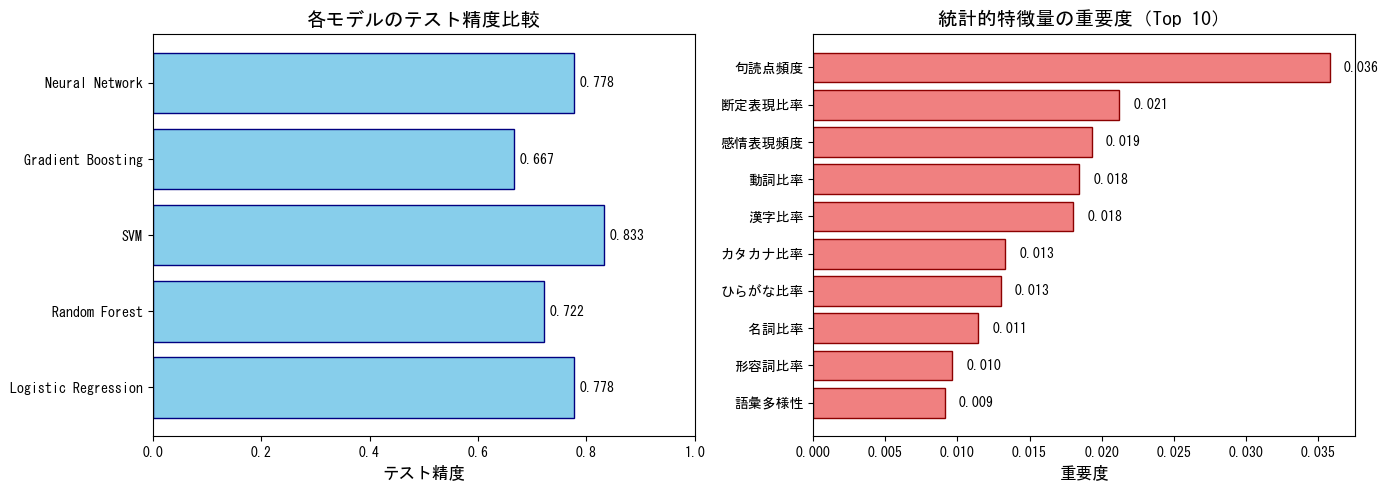


✅ 可視化完了


In [11]:
# オプション: 結果の可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
plt.rcParams['axes.unicode_minus'] = False

# モデル性能の比較棒グラフ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# テスト精度の比較
model_names = list(results.keys())
test_accuracies = [results[m]['test_accuracy'] for m in model_names]

axes[0].barh(model_names, test_accuracies, color='skyblue', edgecolor='navy')
axes[0].set_xlabel('テスト精度', fontsize=12)
axes[0].set_title('各モデルのテスト精度比較', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1.0)
for i, v in enumerate(test_accuracies):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 統計的特徴量の重要度（Random Forestの場合）
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_[:len(FEATURE_NAMES)]
    
    # 重要度でソート
    indices = np.argsort(importances)[-10:]  # Top 10
    
    axes[1].barh([FEATURE_NAMES[i] for i in indices], 
                 importances[indices], 
                 color='lightcoral', 
                 edgecolor='darkred')
    axes[1].set_xlabel('重要度', fontsize=12)
    axes[1].set_title('統計的特徴量の重要度（Top 10）', fontsize=14, fontweight='bold')
    for i, v in enumerate(importances[indices]):
        axes[1].text(v + 0.001, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n✅ 可視化完了")


## まとめ

### 実装内容
本プロジェクトでは、日本語テキストの著者推定システムを構築しました。

#### 主な特徴
1. **データ前処理**
   - ルビ・注釈の除去
   - テキスト正規化
   - 品質フィルタリング

2. **特徴量抽出（165次元）**
   - **統計的特徴量（15種類）**: 文長、文字種比率、品詞比率、語彙多様性、文体指標など
   - **N-gram特徴量（150種類）**: 文字2-gram/3-gramによる文体パターン

3. **機械学習モデル**
   - Logistic Regression
   - Random Forest
   - SVM (RBF kernel)
   - Gradient Boosting
   - Neural Network

4. **評価手法**
   - 5-fold Cross Validation
   - Train/Test Split (80/20)
   - 詳細な分類レポート

### 今後の改善案
- より多様なテキストデータの収集
- BERT等の事前学習済み言語モデルの活用
- アンサンブル学習の導入
- ハイパーパラメータチューニングの自動化
